In [1]:
import pandas as pd
import os
from matplotlib import colormaps as cm
import numpy as np
from scipy.stats import pearsonr
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from sklearn.metrics import r2_score

In [2]:
pred_df = pd.read_csv(f"../Results/linkprediction_results.csv") 

homophily_df = pd.read_csv("../Results/homophily_results_training.csv").set_index("dataset")
preds_arr = []
for (dataset, k), row in pred_df.pivot(index=['dataset', 'k'], columns='homophily_feature', 
                                  values=['rel_auc_pr', 'baseline', 'std_err']).iterrows():
    preds_arr.append({
        'dataset': dataset,
        'k': k,
        'rel_auc_pr': row[('rel_auc_pr', False)],
        'rel_auc_pr_homophily': row[('rel_auc_pr', True)],
        'std_err': 10*row[('std_err', False)],
        'std_err_homophily': 10*row[('std_err', True)],
        'baseline': row[('baseline', False)],
        'hypergraph_score': homophily_df.loc[dataset, f'hypergraph_score_{k}'],
        'simplicial_score': homophily_df.loc[dataset, f'simplicial_score_{k}'],
        'log_hypergraph_score': np.log(homophily_df.loc[dataset, f'hypergraph_score_{k}']),
        'log_simplicial_score': np.log(homophily_df.loc[dataset, f'simplicial_score_{k}'])
    })
    
pred_df = pd.DataFrame(preds_arr)
full_df = pd.merge(pred_df, homophily_df, on='dataset').dropna(subset=['rel_auc_pr'])

In [3]:
full_df['diff'] = (full_df['rel_auc_pr_homophily'] - full_df['rel_auc_pr'])

full_df['abs_log_simplicial'] = np.abs(np.log(full_df['simplicial_score']))
full_df['abs_log_hypergraph'] = np.abs(np.log(full_df['hypergraph_score']))

In [4]:
# preprocess dataframe for plotting
plot_df = full_df.sort_values(by='log_simplicial_score')


contact_datasets = ["cont-hospital", "cont-workplace-13", "cont-workplace-15", 
                "cont-village", "cont-primary-school", "cont-high-school"]

email_datasets = ["email-Enron"]

coauthorship_datasets = ["coauth-dblp"]

political_datasets = ["bills-senate", "bills-house", ]

drug_datasets = ["hosp-DAWN"]


for ind, row in plot_df.iterrows():
    if row['dataset'] in contact_datasets:
        plot_df.loc[ind, 'Category'] = 'cont'
    elif row['dataset'] in email_datasets:
        plot_df.loc[ind, 'Category'] = 'email'
    elif row['dataset'] in coauthorship_datasets:
        plot_df.loc[ind, 'Category'] = 'coauth'
    elif row['dataset'] in political_datasets:
        plot_df.loc[ind, 'Category'] = 'bills'
    elif row['dataset'] in drug_datasets:
        plot_df.loc[ind, 'Category'] = 'hosp'
        
# Set color code
c_dict = {'cont':'red', 'email':'green', 'coauth':'blue', 
          'bills':'gold', 'hosp':'orange'}

plot_df['scattercolor'] = plot_df['Category'].map(c_dict)

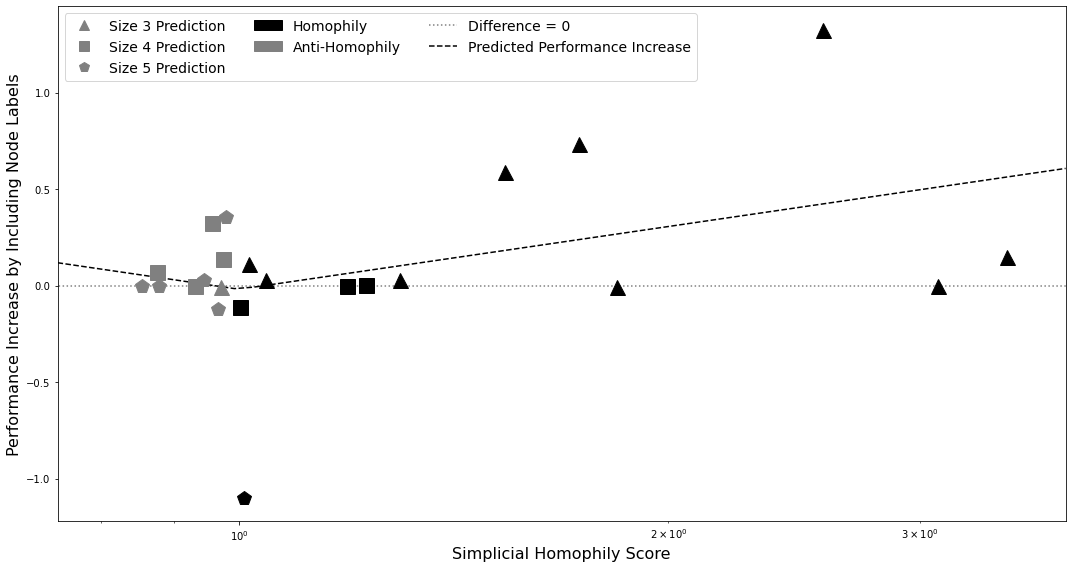

In [5]:
fig, ax = plt.subplots(figsize=(15, 8))
# plot_df.plot.scatter(x='x', y='diff')

# full_df.plot.scatter(x='abs_log_simplicial', y='diff')

x = plot_df['simplicial_score']
y = plot_df['diff']

fit_x = plot_df['abs_log_simplicial']
fit = np.polyfit(fit_x, y, 1)
f = np.poly1d(fit)

shape_dict = {3: "^", 4: "s", 5: "p"}
shapes = plot_df['k'].map(shape_dict)


ax.hlines(0, -1, 23, linestyles=':', color='grey', label='Difference = 0')

plot_x = np.linspace(0.99*min(x) - 0.1, 1.1*max(x), 100)

ax.plot(plot_x,f(np.abs(np.log(plot_x))),  '--', color='black', label='Predicted Performance Increase')

handles, labels = ax.get_legend_handles_labels()

homophily_patch = mpatches.Patch(color='black', label='Homophily')
antihomophily_patch = mpatches.Patch(color='grey', label='Anti-Homophily')

handles = [homophily_patch, antihomophily_patch] + handles

for k in [5,4,3]:
    v = shape_dict[k]
    handles = [mlines.Line2D([], [], color='grey', marker=v, linestyle='None',
                          markersize=10, label=f'Size {k} Prediction')] + handles
    

e = (plot_df['std_err'] + plot_df['std_err_homophily']) * 0


# for (k, v) in shape_dict.items():
#     for (pref, c) in c_dict.items():
#         idxs = (shapes == v) & (plot_df['scattercolor'] == c)
#         ax.errorbar(x[idxs], y[idxs], yerr=e[idxs], fmt=v, c = c, markersize=10)

for (k, v) in shape_dict.items():
    neg_idxs = (shapes == v) & (plot_df['simplicial_score'] < 1)
    pos_idxs = (shapes == v) & (plot_df['simplicial_score'] > 1)
    ax.errorbar(x[neg_idxs], y[neg_idxs], yerr=e[neg_idxs], fmt=v, c = 'grey', markersize=15)
    ax.errorbar(x[pos_idxs], y[pos_idxs], yerr=e[pos_idxs], fmt=v, c = 'black', markersize=15)

ax.legend(handles=handles, loc='upper left', fontsize=14, ncol=3)


ax.set_ylabel("Performance Increase by Including Node Labels", fontsize=16)
ax.set_xlabel("Simplicial Homophily Score", fontsize=16)

ax.set_xlim(min(plot_x), max(plot_x))

ax.semilogx()
fig.tight_layout()
# fig.savefig("linkprediction.eps", format='eps')